# Gaussian Mixture Model (GMM) and Expectation-Maximization (EM) Algorithm

This notebook implements GMM using the EM algorithm from scratch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
import seaborn as sns

sns.set_style('whitegrid')

## GMM with EM Algorithm Implementation

In [2]:
class GMM_EM:
    def __init__(self, n_components=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
    def initialize_parameters(self, X):
        """Initialize means, covariances, and weights"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        # Random initialization of means
        random_idx = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[random_idx]
        
        # Initialize covariances as identity matrices
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])
        
        # Initialize weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components
        
    def e_step(self, X):
        """Expectation step: compute responsibilities"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        
        # Normalize responsibilities
        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities /= responsibilities_sum + 1e-10
        
        return responsibilities
    
    def m_step(self, X, responsibilities):
        """Maximization step: update parameters"""
        n_samples, n_features = X.shape
        
        for k in range(self.n_components):
            resp_k = responsibilities[:, k]
            total_resp = resp_k.sum()
            
            # Update weights
            self.weights[k] = total_resp / n_samples
            
            # Update means
            self.means[k] = (resp_k[:, np.newaxis] * X).sum(axis=0) / total_resp
            
            # Update covariances
            diff = X - self.means[k]
            self.covariances[k] = (resp_k[:, np.newaxis, np.newaxis] * 
                                   diff[:, :, np.newaxis] * diff[:, np.newaxis, :]).sum(axis=0) / total_resp
            # Add regularization for numerical stability
            self.covariances[k] += np.eye(n_features) * 1e-6
    
    def compute_log_likelihood(self, X):
        """Compute log-likelihood of the data"""
        n_samples = X.shape[0]
        log_likelihood = 0
        
        for i in range(n_samples):
            sample_likelihood = 0
            for k in range(self.n_components):
                sample_likelihood += self.weights[k] * multivariate_normal.pdf(
                    X[i], mean=self.means[k], cov=self.covariances[k]
                )
            log_likelihood += np.log(sample_likelihood + 1e-10)
        
        return log_likelihood
    
    def fit(self, X):
        """Fit GMM using EM algorithm"""
        self.initialize_parameters(X)
        prev_log_likelihood = -np.inf
        self.log_likelihoods = []
        
        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self.e_step(X)
            
            # M-step
            self.m_step(X, responsibilities)
            
            # Compute log-likelihood
            log_likelihood = self.compute_log_likelihood(X)
            self.log_likelihoods.append(log_likelihood)
            
            # Check for convergence
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                print(f"Converged at iteration {iteration + 1}")
                break
            
            prev_log_likelihood = log_likelihood
        
        return self
    
    def predict(self, X):
        """Predict cluster labels"""
        responsibilities = self.e_step(X)
        return np.argmax(responsibilities, axis=1)
    
    def predict_proba(self, X):
        """Predict cluster probabilities"""
        return self.e_step(X)

## Generate Synthetic Data

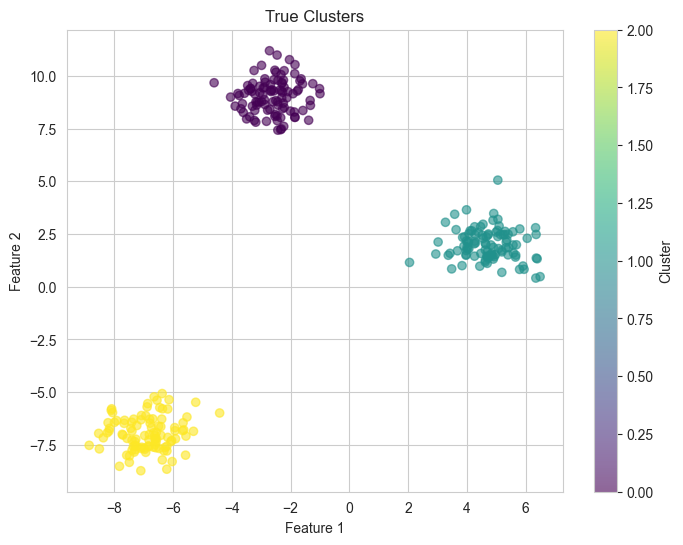

In [3]:
# Generate sample data
X, y_true = make_blobs(n_samples=300, centers=3, n_features=2, 
                       cluster_std=0.8, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', alpha=0.6)
plt.title('True Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

## Fit Custom GMM Implementation

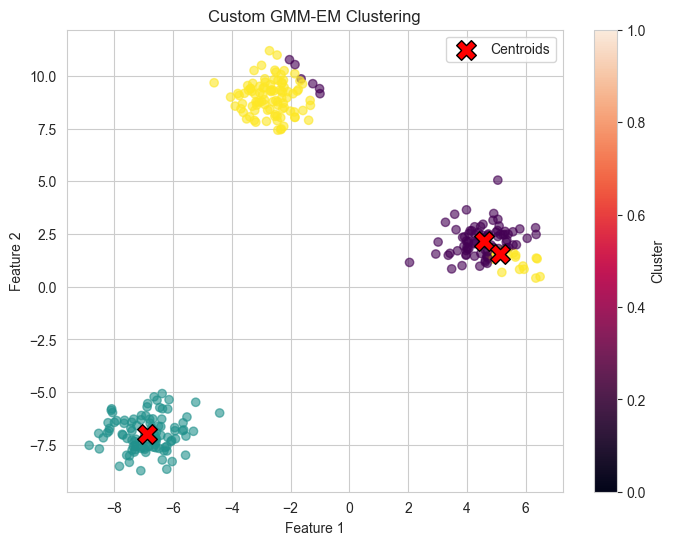

In [4]:
# Fit our custom GMM
gmm_custom = GMM_EM(n_components=3, max_iter=100, random_state=42)
gmm_custom.fit(X)
labels_custom = gmm_custom.predict(X)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis', alpha=0.6)
plt.scatter(gmm_custom.means[:, 0], gmm_custom.means[:, 1], 
           c='red', marker='X', s=200, edgecolors='black', label='Centroids')
plt.title('Custom GMM-EM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.colorbar(label='Cluster')
plt.show()

## Plot Log-Likelihood Convergence

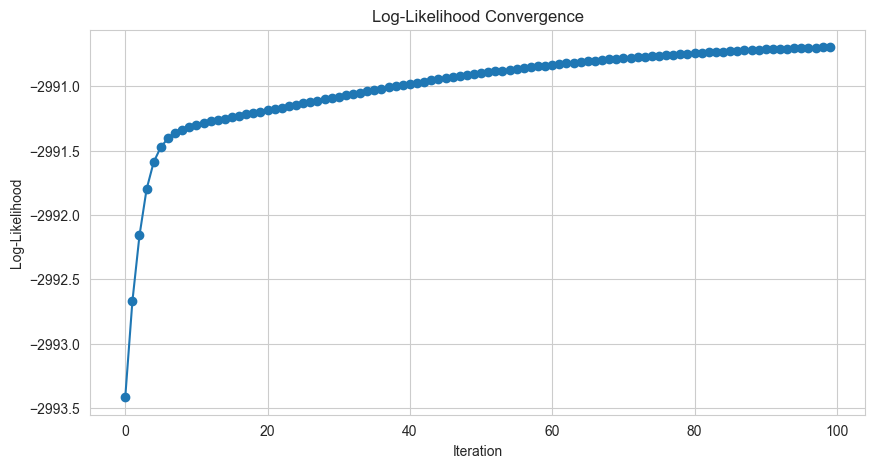

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(gmm_custom.log_likelihoods, marker='o')
plt.title('Log-Likelihood Convergence')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()

## Compare with Scikit-learn GMM

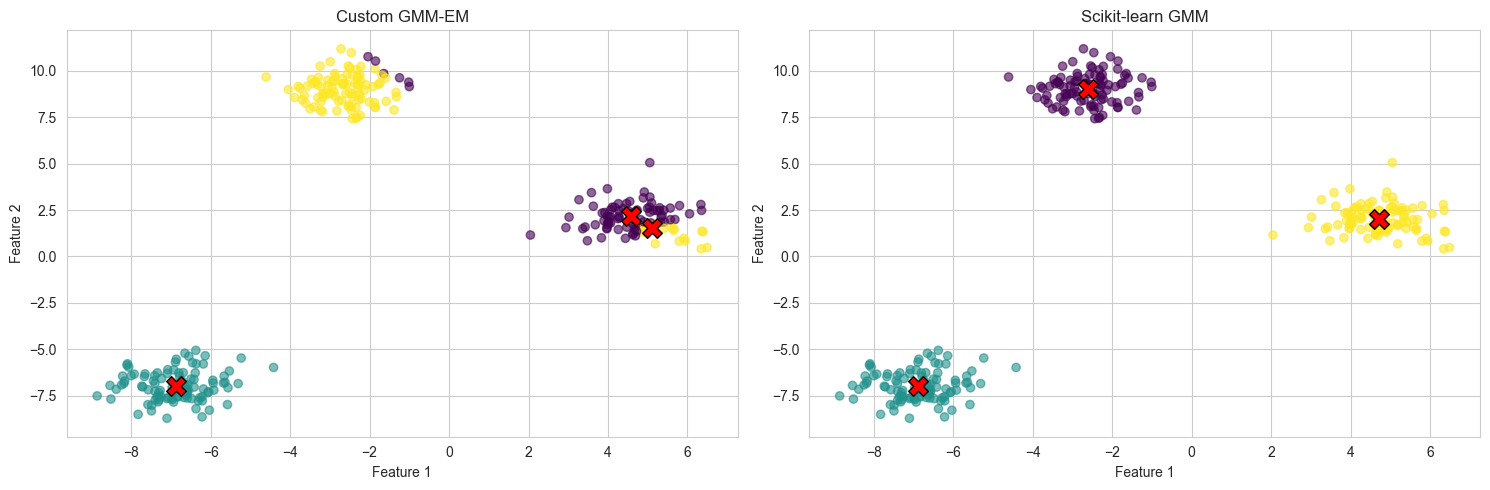

In [6]:
# Fit sklearn GMM
gmm_sklearn = GaussianMixture(n_components=3, random_state=42)
gmm_sklearn.fit(X)
labels_sklearn = gmm_sklearn.predict(X)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Custom implementation
axes[0].scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis', alpha=0.6)
axes[0].scatter(gmm_custom.means[:, 0], gmm_custom.means[:, 1], 
               c='red', marker='X', s=200, edgecolors='black')
axes[0].set_title('Custom GMM-EM')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Sklearn implementation
axes[1].scatter(X[:, 0], X[:, 1], c=labels_sklearn, cmap='viridis', alpha=0.6)
axes[1].scatter(gmm_sklearn.means_[:, 0], gmm_sklearn.means_[:, 1], 
               c='red', marker='X', s=200, edgecolors='black')
axes[1].set_title('Scikit-learn GMM')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

## Visualize Gaussian Ellipses

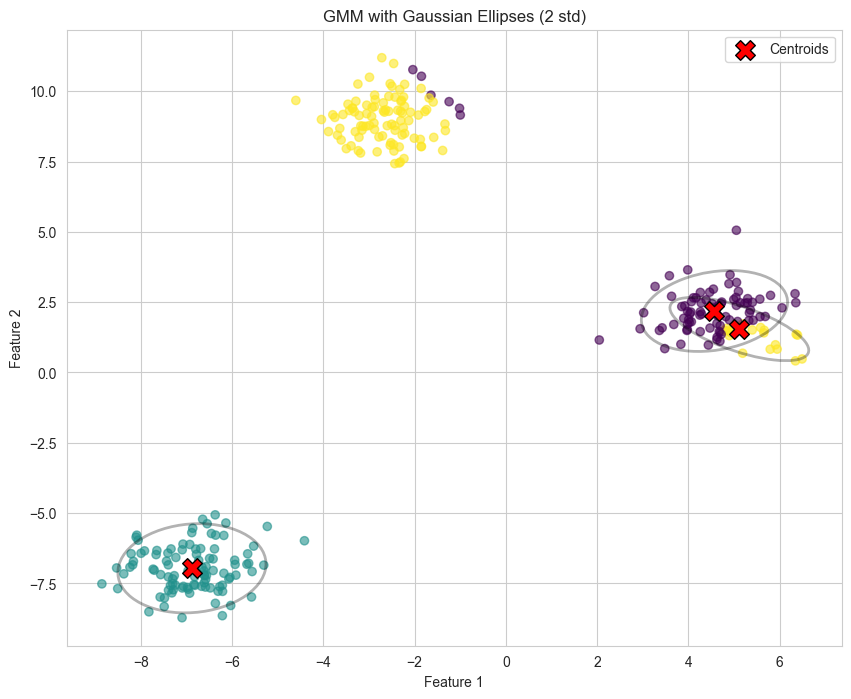

In [7]:
from matplotlib.patches import Ellipse

def plot_gaussian_ellipses(means, covariances, ax, n_std=2.0, alpha=0.3):
    """Plot Gaussian ellipses for each component"""
    for mean, cov in zip(means, covariances):
        # Eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        width, height = 2 * n_std * np.sqrt(eigenvalues)
        
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                         alpha=alpha, edgecolor='black', facecolor='none', linewidth=2)
        ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis', alpha=0.6)
ax.scatter(gmm_custom.means[:, 0], gmm_custom.means[:, 1], 
          c='red', marker='X', s=200, edgecolors='black', label='Centroids')
plot_gaussian_ellipses(gmm_custom.means, gmm_custom.covariances, ax)
ax.set_title('GMM with Gaussian Ellipses (2 std)')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend()
plt.show()

## Model Selection: Optimal Number of Components

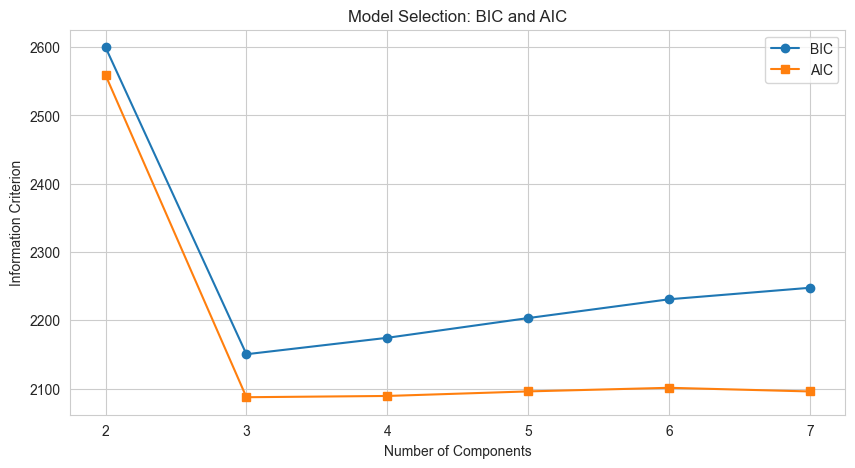

Optimal number of components (BIC): 3
Optimal number of components (AIC): 3


In [8]:
# Test different numbers of components
n_components_range = range(2, 8)
bic_scores = []
aic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))
    aic_scores.append(gmm.aic(X))

plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.plot(n_components_range, aic_scores, marker='s', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.title('Model Selection: BIC and AIC')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal number of components (BIC): {n_components_range[np.argmin(bic_scores)]}")
print(f"Optimal number of components (AIC): {n_components_range[np.argmin(aic_scores)]}")